# SPH6004 Group project Task 1 (Multi-label Classification Model) - Part 2


This file is for SPH6004 Group project Task 1 (Multi-label Classification Model) – MLP Classifier.  
In this part, we apply a Multi-Layer Perceptron (MLP) to evaluate how deeper neural network architectures perform on multi-label classification.  
The results are compared with the logistic regression baseline from Part 1 to assess improvements in metrics such as AUC, F1-score, precision, and recall.

In [1]:
import os
import os.path
import random
import numpy as np
import pandas as pd
from typing import Dict, List
import torch
from torch.utils.data import Dataset
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [4]:
### Define helper functions for dataset class

def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    return torch.tensor(embedding_values)

#### Define Dataset Class
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]

    # 80% training data (train), 10% validation (valid), 10% test data (test)
    split_ratio = [0.8, 0.1, 0.1]

    def __init__(
        self,
        embedpath,
        csvpath,
        metacsvpath,
        views=["PA"],
        data_aug=None,
        seed=0,
        unique_patients=True,
        mode=["train", "valid", "test"][0],
    ):
        super().__init__()
        np.random.seed(seed)

        self.pathologies = sorted(self.pathologies)
        self.mode = mode
        self.embedpath = embedpath
        self.data_aug = data_aug
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        self.metacsvpath = metacsvpath
        self.metacsv = pd.read_csv(self.metacsvpath)

        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        # Keep only the desired view
        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        n_row = self.csv.shape[0]
        # Split data
        if self.mode == "train":
            self.csv = self.csv[: int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[
                int(n_row * self.split_ratio[0]) : int(
                    n_row * (self.split_ratio[0] + self.split_ratio[1])
                )
            ]
        elif self.mode == "test":
            self.csv = self.csv[-int(n_row * self.split_ratio[-1]) :]
        else:
            raise ValueError(
                f"attr:mode must be [train, valid, test] but got {self.mode}"
            )

        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            labels.append(mask.values)

        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[self.labels == -1] = np.nan

        # rename pathologies
        self.pathologies = list(
            np.char.replace(self.pathologies, "Pleural Effusion", "Effusion")
        )

        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def string(self):
        return self.__class__.__name__ + " num_samples={} views={}".format(
            len(self), self.views
        )

    def limit_to_selected_views(self, views):
        if type(views) is not list:
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv.view.fillna("UNKNOWN", inplace=True)
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]

        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])

        embed_file = os.path.join(
            self.embedpath,
            "p" + subjectid[:2],
            "p" + subjectid,
            "s" + studyid,
            dicom_id + ".tfrecord",
        )
        sample["embedding"] = load_embedding(embed_file)

        return sample

In [5]:
def extract_X_y(dataset):
    X = []
    y = []
    for sample in dataset:
        X.append(sample['embedding'])         # (embedding_dim,)
        y.append(torch.tensor(sample['lab'])) # (num_classes,)
    return torch.stack(X), torch.stack(y)

def find_best_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        best_thresh = 0.5
        best_f1 = 0.0
        for t in np.arange(0.1, 0.9, 0.05):
            y_pred_i = (y_probs[:, i] >= t).astype(int)
            mask = ~np.isnan(y_true[:, i])
            if np.sum(mask) == 0:
                continue
            f1 = f1_score(y_true[mask, i], y_pred_i[mask])
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        thresholds.append(best_thresh)
    return thresholds

[Cache] No cache found. Building dataset & computing features...
[Cache] Data saved to: cached_data.pt
New best model found at epoch 1 (Val Loss = 0.1505)
New best model found at epoch 2 (Val Loss = 0.1466)
New best model found at epoch 4 (Val Loss = 0.1459)
Epoch [10/60] - Train Loss: 0.1572 | Val Loss: 0.1490
New best model found at epoch 11 (Val Loss = 0.1458)
Epoch [20/60] - Train Loss: 0.1568 | Val Loss: 0.1525
New best model found at epoch 25 (Val Loss = 0.1456)
Epoch [30/60] - Train Loss: 0.1562 | Val Loss: 0.1469
Epoch [40/60] - Train Loss: 0.1565 | Val Loss: 0.1532
Epoch [50/60] - Train Loss: 0.1566 | Val Loss: 0.1443
New best model found at epoch 50 (Val Loss = 0.1443)
Epoch [60/60] - Train Loss: 0.1558 | Val Loss: 0.1533

Finished Training. Best val_loss = 0.1442859646948901

Evaluating on TEST SET...
Test Class 0: AUC=0.8970, Precision=0.5927, Recall=0.4731, F1=0.5262
Test Class 1: AUC=0.8985, Precision=0.4829, Recall=0.6000, F1=0.5351
Test Class 2: AUC=0.8990, Precision=0.

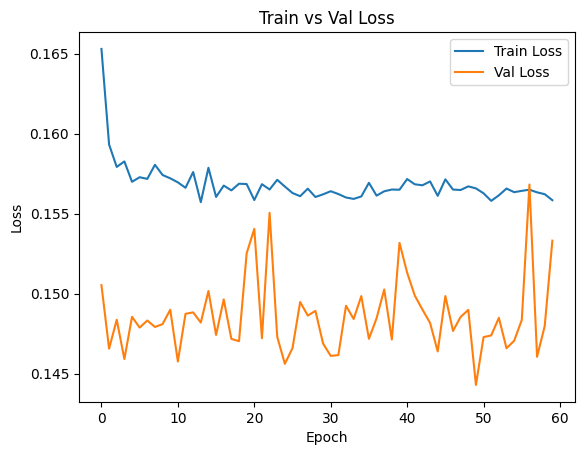

In [ ]:
# ============ MAIN CODE ============

import matplotlib.pyplot as plt

import os
use_cache = True
cache_file = "cached_data.pt"

embedpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0\\files"
csvpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\mimic-cxr-2.0.0-metadata.csv"


if use_cache and os.path.exists(cache_file):
    print(f"[Cache] Loading data from: {cache_file}")
    cached = torch.load(cache_file)
    X_train_tensor = cached["X_train_tensor"]
    X_val_tensor   = cached["X_val_tensor"]
    X_test_tensor  = cached["X_test_tensor"]
    y_train        = cached["y_train"]
    y_val          = cached["y_val"]
    y_test         = cached["y_test"]
    best_thresholds = cached["best_thresholds"]  
    print(f"[Cache] Loaded data shape: X_train {X_train_tensor.shape}, X_val {X_val_tensor.shape}, X_test {X_test_tensor.shape}")

else:
    print("[Cache] No cache found. Building dataset & computing features...")

    # 1) Dataset
    train_dataset = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="train")
    val_dataset   = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="valid")
    test_dataset  = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="test")

    # 2)Extract and normalize features
    X_train, y_train = extract_X_y(train_dataset)
    X_val,   y_val   = extract_X_y(val_dataset)
    X_test,  y_test  = extract_X_y(test_dataset)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.numpy())
    X_val_scaled   = scaler.transform(X_val.numpy())
    X_test_scaled  = scaler.transform(X_test.numpy())

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_scaled,   dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32)

    # Temporarily define a placeholder for best_thresholds (to be updated after training/validation)
    best_thresholds = [0.5]* y_train.shape[1]

    if use_cache:
        torch.save({
            "X_train_tensor": X_train_tensor,
            "X_val_tensor": X_val_tensor,
            "X_test_tensor": X_test_tensor,
            "y_train": y_train,
            "y_val": y_val,
            "y_test": y_test,
            "best_thresholds": best_thresholds
        }, cache_file)
        print(f"[Cache] Data saved to: {cache_file}")

# Create DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor,   y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test),  batch_size=batch_size, shuffle=False)


# ===MLP Model Description===
#We implemented a single hidden-layer MLP with 512 units, ReLU activation, dropout regularization, and sigmoid output for multi-label classification.
class CXRClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CXR_model1 = CXRClassifier(input_dim=X_train_tensor.shape[1], output_dim=y_train.shape[1])
CXR_model1.to(device)

#We optimized the model using the Adam optimizer, and binary cross-entropy loss (BCELoss) is used as the training objective.
optimizer = optim.Adam(CXR_model1.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

#The model was trained for 60 epochs, and the best model was selected based on validation loss.
num_epochs = 60
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  
    # TRAIN
    CXR_model1.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        inputs = x_batch.to(device).float()
        labels = y_batch.to(device).float()

        mask = ~torch.isnan(labels)
        labels = torch.nan_to_num(labels, nan=0.0)

        outputs = CXR_model1(inputs)
        loss = criterion(outputs[mask], labels[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # VALID
    CXR_model1.eval()
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            inputs = x_batch.to(device).float()
            labels = y_batch.to(device).float()

            mask = ~torch.isnan(labels)
            labels = torch.nan_to_num(labels, nan=0.0)

            outputs = CXR_model1(inputs)
            loss = criterion(outputs[mask], labels[mask])
            val_loss += loss.item()

            y_val_true.append(labels.cpu().numpy())
            y_val_pred.append(outputs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)

    y_val_true = np.concatenate(y_val_true, axis=0)
    y_val_pred = np.concatenate(y_val_pred, axis=0)

    # Update best_thresholds
    best_thresholds = find_best_thresholds(y_val_true, y_val_pred)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = CXR_model1.state_dict()
        print(f"New best model found at epoch {epoch+1} (Val Loss = {avg_val_loss:.4f})")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

CXR_model1.load_state_dict(best_model_state)
print("\nFinished Training. Best val_loss =", best_val_loss)

print("\nEvaluating on TEST SET...")
CXR_model1.eval()
y_true_all, y_pred_all = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        inputs = x_batch.to(device).float()
        labels = y_batch.to(device).float()

        outputs = CXR_model1(inputs)
        y_true_all.append(labels.cpu().numpy())
        y_pred_all.append(outputs.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

# Use the best_thresholds found during the last validation phase
y_pred_bin = np.zeros_like(y_pred_all)
for i in range(y_pred_all.shape[1]):
    y_pred_bin[:, i] = (y_pred_all[:, i] >= best_thresholds[i]).astype(int)

aucs, precisions, recalls, f1s = [], [], [], []
for i in range(y_true_all.shape[1]):
    mask = ~np.isnan(y_true_all[:, i])
    if np.sum(mask) == 0:
        aucs.append(np.nan)
        precisions.append(np.nan)
        recalls.append(np.nan)
        f1s.append(np.nan)
    else:
        y_true_i = y_true_all[mask, i]
        y_prob_i = y_pred_all[mask, i]
        y_pred_i = y_pred_bin[mask, i]

        aucs.append(roc_auc_score(y_true_i, y_prob_i))
        precisions.append(precision_score(y_true_i, y_pred_i))
        recalls.append(recall_score(y_true_i, y_pred_i))
        f1s.append(f1_score(y_true_i, y_pred_i))

for i in range(len(aucs)):
    print(f"Test Class {i}: AUC={aucs[i]:.4f}, Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")

print(f"\nTest Set Average AUC:       {np.nanmean(aucs):.4f}")
print(f"Test Set Average Precision: {np.nanmean(precisions):.4f}")
print(f"Test Set Average Recall:    {np.nanmean(recalls):.4f}")
print(f"Test Set Average F1-score:  {np.nanmean(f1s):.4f}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Val Loss")
plt.show()

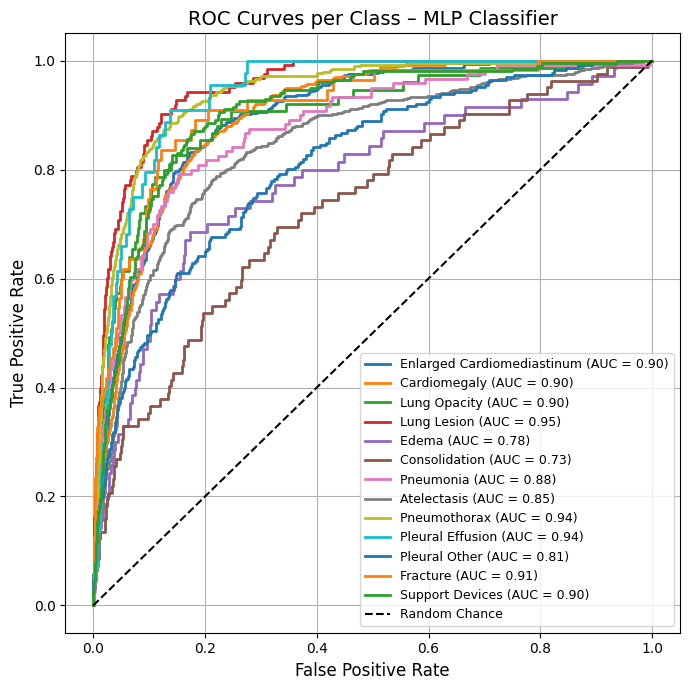

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


pathologies = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
]

# create plot 
plt.figure(figsize=(7, 7))
for i in range(len(pathologies)):
    mask = ~np.isnan(y_true_all[:, i])
    if np.sum(mask) == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_all[mask, i], y_pred_all[mask, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{pathologies[i]} (AUC = {roc_auc:.2f})')

# dash line：random situation 
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Chance')

# plot setting 
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves per Class – MLP Classifier', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=1, frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()



Comments for Task 1 Part 2 (MLP model)
- The MLP model demonstrates overall improved performance compared to the logistic regression baseline in Part 1.
- Several pathology classes achieve excellent AUC scores, including Lung Lesion (AUC = 0.95), Pneumothorax (AUC = 0.94), and Pleural Effusion (AUC = 0.94).
- Even previously underperforming classes such as Edema show moderate improvement (AUC = 0.78 vs 0.68 in Part 1).
- The model’s ability to capture non-linear relationships likely contributes to the better results across most classes.
- This suggests that using deeper architectures like MLP can significantly enhance multi-label classification performance on chest X-ray embeddings.